In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import datetime
import re

pd.set_option("display.max_rows", 1000)
pd.set_option("max_columns", 100)
pd.set_option("max_colwidth",10000)
import requests 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
try:
    keras.backend.clear_session() # 把舊的 Graph 清掉
except:
    pass

In [3]:
#資料路徑
DATASET_PATH  = 'ml100-03-final/image_data'

# 影像大小
IMAGE_SIZE = (240, 240)

# 影像類別數
NUM_CLASSES = 5

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 32

# 凍結網路層數
FREEZE_LAYERS = -2

# Epoch 數
NUM_EPOCHS = 20

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'ml100-03-final/model-resnet50-basic.h5'

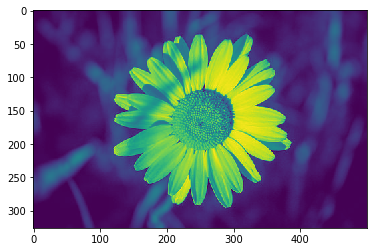

In [4]:
import numpy as np
import cv2

# Load an color image in grayscale
img = cv2.imread(DATASET_PATH + '/train/daisy/0a3e7507742e246b3a2e630debbbaf99.jpg',0)
plt.imshow(img)

In [6]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
import keras
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import sys
from PIL import Image
import PIL

In [7]:
# 透過 data augmentation 產生訓練與驗證用的影像資料

train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                  validation_split=0.2)

train_generator = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  color_mode="rgb",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=42,
                                                    subset='training'
                                                  )

validation_generator = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  color_mode="rgb",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=42,
                                                    subset='validation'
                                                  )

Found 2260 images belonging to 5 classes.
Found 563 images belonging to 5 classes.


In [8]:
# 輸出各類別的索引值
for cls, idx in train_generator.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

Class #0 = daisy
Class #1 = dandelion
Class #2 = rose
Class #3 = sunflower
Class #4 = tulip


In [9]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(DATASET_PATH + '/test/',
                                                target_size=IMAGE_SIZE,
                                                color_mode="rgb",
                                                batch_size=1,
                                                class_mode=None,
                                                shuffle=False,
                                                seed=42)

Found 2000 images belonging to 1 classes.


In [10]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
print(STEP_SIZE_TRAIN, STEP_SIZE_VALID)

70 17


In [11]:
# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers

net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))

/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [12]:
import keras
x = net.output
x = keras.layers.Flatten()(x)

# 增加 DropOut layer
x = keras.layers.Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = keras.layers.Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

In [13]:
# 設定凍結與要進行訓練的網路層
net_final = keras.models.Model(inputs=net.input, outputs=output_layer)

for i,layer in enumerate(net_final.layers):
    print(i,layer.name)

0 input_1
1 conv1_pad
2 conv1
3 bn_conv1
4 activation_1
5 pool1_pad
6 max_pooling2d_1
7 res2a_branch2a
8 bn2a_branch2a
9 activation_2
10 res2a_branch2b
11 bn2a_branch2b
12 activation_3
13 res2a_branch2c
14 res2a_branch1
15 bn2a_branch2c
16 bn2a_branch1
17 add_1
18 activation_4
19 res2b_branch2a
20 bn2b_branch2a
21 activation_5
22 res2b_branch2b
23 bn2b_branch2b
24 activation_6
25 res2b_branch2c
26 bn2b_branch2c
27 add_2
28 activation_7
29 res2c_branch2a
30 bn2c_branch2a
31 activation_8
32 res2c_branch2b
33 bn2c_branch2b
34 activation_9
35 res2c_branch2c
36 bn2c_branch2c
37 add_3
38 activation_10
39 res3a_branch2a
40 bn3a_branch2a
41 activation_11
42 res3a_branch2b
43 bn3a_branch2b
44 activation_12
45 res3a_branch2c
46 res3a_branch1
47 bn3a_branch2c
48 bn3a_branch1
49 add_4
50 activation_13
51 res3b_branch2a
52 bn3b_branch2a
53 activation_14
54 res3b_branch2b
55 bn3b_branch2b
56 activation_15
57 res3b_branch2c
58 bn3b_branch2c
59 add_5
60 activation_16
61 res3c_branch2a
62 bn3c_branch2a

In [14]:
net_final.layers[-2:]

In [15]:
FREEZE_LAYERS = -2
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
                  loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# 輸出整個網路結構
print(net_final.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 246, 246, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 120, 120, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 120, 120, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [17]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor="val_loss", 
                          patience=30, 
                          verbose=1
                          )

In [18]:
# 訓練模型
net_final.fit_generator(train_generator,
                        steps_per_epoch = STEP_SIZE_TRAIN,
                        validation_data = validation_generator,
                        validation_steps = STEP_SIZE_VALID,
                        epochs = NUM_EPOCHS,
                        verbose=1,
                       callbacks=[earlystop]
                       )

# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

Epoch 1/20
70/70 [==============================] - 1013s 14s/step - loss: 1.7884 - accuracy: 0.5871 - val_loss: 1.7654 - val_accuracy: 0.5974
Epoch 2/20
70/70 [==============================] - 974s 14s/step - loss: 1.0795 - accuracy: 0.7433 - val_loss: 0.7683 - val_accuracy: 0.6817
Epoch 3/20
70/70 [==============================] - 975s 14s/step - loss: 1.0182 - accuracy: 0.7711 - val_loss: 2.0397 - val_accuracy: 0.6573
Epoch 4/20
70/70 [==============================] - 1004s 14s/step - loss: 0.7947 - accuracy: 0.8061 - val_loss: 1.0581 - val_accuracy: 0.7514
Epoch 5/20
70/70 [==============================] - 963s 14s/step - loss: 0.7865 - accuracy: 0.8169 - val_loss: 0.8993 - val_accuracy: 0.7213
Epoch 6/20
70/70 [==============================] - 954s 14s/step - loss: 0.7133 - accuracy: 0.8357 - val_loss: 1.2908 - val_accuracy: 0.7269
Epoch 7/20
70/70 [==============================] - 995s 14s/step - loss: 0.7176 - accuracy: 0.8393 - val_loss: 2.0984 - val_accuracy: 0.7702
Epoc

In [19]:
score = net_final.evaluate(validation_generator, verbose=0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 1.4443070888519287
Val accuracy: 0.7548845410346985


In [20]:
score = net_final.evaluate_generator(generator=validation_generator,
steps=STEP_SIZE_VALID)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 1.1895653009414673
Val accuracy: 0.779411792755127


### 驗證和預測 ###

In [29]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=net_final.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

2000/2000 [==============================] - 774s 387ms/step


In [30]:
predicted_class_indices=np.argmax(pred,axis=1)

In [34]:
labels

{0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}

In [35]:
flower_mapping = {'daisy':0, 'dandelion':1, 'rose':2, 'sunflower':3, 'tulip':4}

In [36]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in labels]

In [43]:
filenames=test_generator.filenames


results=pd.DataFrame({"id":filenames,
                      "prediction":predictions})
results['flower_class'] = results.prediction.apply(lambda x: flower_mapping[x])
results['id'] = results.id.apply(lambda x: (x.split('/')[1]).replace('.jpg',''))
results.head()

ValueError: arrays must all be same length

In [27]:
results[['id','flower_class']].to_csv("results.csv",index=False)

NameError: name 'results' is not defined

In [ ]:
results.count()

In [ ]:
x_batch, y_batch = next(train_generator)

In [ ]:
plt.imshow(x_batch.astype("int")[0])

In [ ]:
train_datagen_small = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                  validation_split=0.2)

train_generator_small = train_datagen_small.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=(128,128),
                                                  color_mode="rgb",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=42,
                                                    subset='training'
                                                  )

In [ ]:
x_batch, y_batch = next(train_generator_small)

In [ ]:
train_generator_small.class_indices

In [ ]:
y_batch[0]

In [ ]:
train_generator_small.filenames[0]

In [ ]:
plt.imshow(x_batch.astype("int")[0])

In [ ]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.preprocessing import image
import sys
import numpy as np

# 從參數讀取圖檔路徑

# 載入訓練好的模型
net = load_model('ml100-03-final/model-resnet50-basic.h5')

cls_list = ['cats', 'dogs']

# 辨識每一張圖
for f in files:
    img = image.load_img(f, target_size=(224, 224))
    if img is None:
        continue
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    pred = net.predict(x)[0]
    top_inds = pred.argsort()[::-1][:5]
    print(f)
    for i in top_inds:
        print('    {:.3f}  {}'.format(pred[i], cls_list[i]))